In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


# Install Packages

In [ ]:
# Install dependencies
!pip install e3nn==0.4.4 opt_einsum ase torch_ema prettytable

# Clone MACE
!git clone --depth 1 https://github.com/ACEsuit/mace.git

!pip install mace/
!pip install -U numpy==2.0

# W (Tungsten)

## Lattice constant

In [ ]:
from ase.build import bulk
from ase.optimize import BFGS, LBFGS
from ase.constraints import UnitCellFilter, ExpCellFilter
from mace.calculators import MACECalculator
from ase.io import write


#model_path = "2023-12-03-mace-128-L1_epoch-199.model"
model_path = "/MACE-MP0b3_A13_MD_ft.model"


# === Parameters ===
element = 'W'
a = 3.15
supercell = (5, 5, 5)
num_spercell_x = supercell[0]

output_file = f"{element}_relaxed_cell.xyz"

# === Create BCC bulk structure ===
atoms = bulk(name=element, crystalstructure='bcc', a=a)*supercell

# === Set MACE calculator ===
calc = MACECalculator(model_path=model_path, device='cpu', default_dtype='float32')
atoms.set_calculator(calc)

# === Enable cell relaxation ===
ucf = UnitCellFilter(atoms)
#ucf = ExpCellFilter (atoms) # Gives same result
dyn = BFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log')
#dyn = LBFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log') # Gives same result
dyn.run(fmax=0.01)

# === Save relaxed structure ===
write(output_file, atoms)

# === Extract final lattice constant ===
relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)
print(f"Relaxed lattice constant (a): {relaxed_a:.6f} Å")



write("train_mace_cubic_True.xyz", atoms, append=False)


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['pt_head', 'default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/tmp/ipython-input-3802113250.py:25: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipython-input-3802113250.py:28: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms)


Relaxed lattice constant (a): -3.190658 Å


## Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from mace.calculators import MACECalculator, mace_mp
from ase.optimize import BFGS



# ---------------------------
# Setup: Load model and atoms
# ---------------------------
#model_path = "2023-12-03-mace-128-L1_epoch-199.model"
model_path = "/MACE-MP0b3_A13_MD_ft.model"


atoms = bulk("W", "bcc", a=3.188, cubic=True)
atoms.calc = MACECalculator(model_path=model_path)


"""
# The structure can be relaxed too but because as A.13 a =3.188 is uded, it does not make sense to do so
opt = BFGS(atoms)
opt.run(fmax=0.01)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()
"""

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = deepcopy(atoms)
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    #===== To produce structures during process =====
    strained_atoms.calc = MACECalculator(model_path=model_path)

    return strained_atoms

def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    # Fit ΔE/V = A delta^2 → C = 2A / factor
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)  # linear fit
    A = coeffs[0]
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    # ________________________________________________

    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    # ________________________________________________

    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta  # symmetric shear
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    # ________________________________________________

    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa  # 1 eV/A^3 = 160.21766208 GPa

print("\nElastic Constants (from MACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.

Elastic Constants (from MACE model):
C11 ≈ 326.37 GPa
C12 ≈ 216.97 GPa
C44 ≈ 77.43 GPa


## Energy vs Volume

/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['pt_head', 'default']
No dtype selected, switching to float64 to match model dtype.


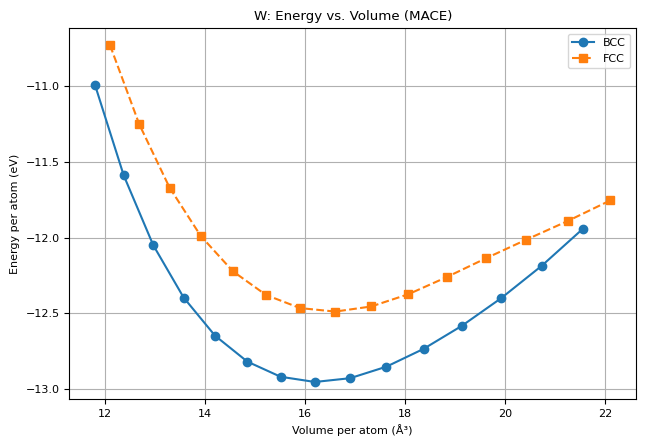

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from mace.calculators import MACECalculator
from ase.optimize import BFGS, LBFGS
from ase.constraints import UnitCellFilter, ExpCellFilter
from ase.io import write


#model_path = "2023-12-03-mace-128-L1_epoch-199.model"
model_path = "/MACE-MP0b3_A13_MD_ft.model"


# --- Setup ---
element = "W"
a0_bcc = 3.188  # Approximate relaxed lattice constant for BCC
a0_fcc = 4.05  # Approximate FCC guess (not stable for W, but useful for comparison)
scaling_factors = np.linspace(0.9, 1.1, 15)

# --- Load MACE calculator ---
calc = MACECalculator(model_path=model_path)

# --- Function to compute E/V for a crystal type ---
def compute_e_vs_v(crystal, a0):
    volumes = []
    energies = []

    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale, cubic=True)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)

        # ________________________________________________

        volumes.append(V_per_atom)
        energies.append(E_per_atom)

    return volumes, energies

# --- Compute for BCC and FCC ---
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# --- Plot ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, en_fcc, 's--', label="FCC")
plt.xlabel("Volume per atom (Å³)")
plt.ylabel("Energy per atom (eV)")
plt.title(f"{element.upper()}: Energy vs. Volume (MACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()







/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['pt_head', 'default']
No dtype selected, switching to float64 to match model dtype.
Saved ΔE–V data to DeltaE_vs_V_W_MACE-MP0b3_A13_MD_ft.csv


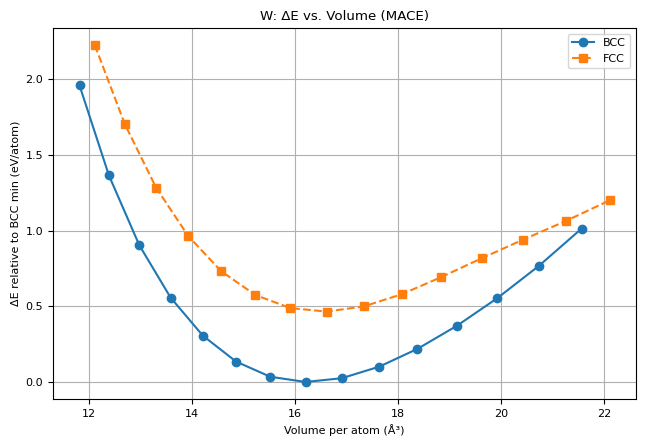

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
from ase.io import write
from mace.calculators import MACECalculator

# --- Setup ---
element = "W"
a0_bcc = 3.188  # Approx relaxed BCC lattice constant
a0_fcc = 4.05   # Approx FCC guess
scaling_factors = np.linspace(0.9, 1.1, 15)

# --- Load MACE calculator ---

#model_path = "2023-12-03-mace-128-L1_epoch-199.model"
model_path = "/MACE-MP0b3_A13_MD_ft.model"


calc = MACECalculator(model_path=model_path)

# --- Function to compute E/V for a crystal type ---
def compute_e_vs_v(crystal, a0):
    volumes, energies = [], []
    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale, cubic=True)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)

        volumes.append(V_per_atom)
        energies.append(E_per_atom)
    return np.array(volumes), np.array(energies)

# --- Compute for BCC and FCC ---
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# --- Shift energies to ΔE relative to BCC minimum ---
E_ref = en_bcc.min()
delta_en_bcc = en_bcc - E_ref
delta_en_fcc = en_fcc - E_ref

# --- Save ΔE–V to CSV (name based on model) ---
df = pd.DataFrame({
    "V_BCC": vol_bcc,
    "DeltaE_BCC": delta_en_bcc,
    "V_FCC": vol_fcc,
    "DeltaE_FCC": delta_en_fcc
})



model_name = os.path.splitext(os.path.basename(model_path))[0]
out_csv = f"DeltaE_vs_V_W_{model_name}.csv"

df.to_csv(out_csv, index=False)
print(f"Saved ΔE–V data to {out_csv}")

# --- Plot ΔE vs V ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
plt.xlabel("Volume per atom (Å³)")
plt.ylabel("ΔE relative to BCC min (eV/atom)")
plt.title(f"{element.upper()}: ΔE vs. Volume (MACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Vacancy formation Ennergy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from ase.optimize import BFGS
from ase import Atoms
from mace.calculators import MACECalculator



#model_path = "2023-12-03-mace-128-L1_epoch-199.model"
model_path = "/MACE-MP0b3_A13_MD_ft.model"


# Parameters
element = "W"
a0 = 3.188
supercell_size = (5, 5, 5)
fmax_tol = 1e-2

# Build bulk supercell
atoms_bulk = bulk(element, 'bcc', a=a0).repeat(supercell_size)
N_bulk = len(atoms_bulk)

# Assign calculator and relax bulk
atoms_bulk.calc = MACECalculator(model_path=model_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)

# To save structure for train
atoms_bulk.get_forces()
write("train_mace_cubic_True.xyz", atoms_bulk, append=True)
# ________________________________________________

E_bulk = atoms_bulk.get_potential_energy()

##### Debug 1
print(f"Bulk energy: {E_bulk:.3f} eV")


# ----------------------
# Vacancy
# ----------------------
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)  # remove one atom from center
atoms_vac.calc = MACECalculator(model_path=model_path)

# ________________________________________________


opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)
E_vac = atoms_vac.get_potential_energy()

# To save structure for train
atoms_vac.get_forces()
write("train_mace_cubic_True.xyz", atoms_vac, append=True)
# ________________________________________________


vacancy_formation_energy = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk


##### Debug 2
print(f"Vacancy formation energy: {vacancy_formation_energy:.3f} eV")


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['pt_head', 'default']
No dtype selected, switching to float64 to match model dtype.


Bulk energy: -1619.283 eV


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['pt_head', 'default']
No dtype selected, switching to float64 to match model dtype.
Vacancy formation energy: 3.717 eV


# Mo (Molybdenum)

## Lattice constant

In [ ]:
from ase.build import bulk
from ase.optimize import BFGS, LBFGS
from ase.constraints import UnitCellFilter, ExpCellFilter
from mace.calculators import MACECalculator
from ase.io import write

# === Parameters ===
element = 'Mo'
a = 3.15
supercell = (5, 5, 5)
num_spercell_x = supercell[0]
model_path = "2023-12-03-mace-128-L1_epoch-199.model"
output_file = f"{element}_relaxed_cell.xyz"

# === Create BCC bulk structure ===
atoms = bulk(name=element, crystalstructure='bcc', a=a)*supercell

# === Set MACE calculator ===
calc = MACECalculator(model_path=model_path, device='cpu', default_dtype='float32')
atoms.set_calculator(calc)

# === Enable cell relaxation ===
ucf = UnitCellFilter(atoms)
#ucf = ExpCellFilter (atoms) # Gives same result
dyn = BFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log')
#dyn = LBFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log') # Gives same result
dyn.run(fmax=0.01)

# === Save relaxed structure ===
write(output_file, atoms)

# === Extract final lattice constant ===
relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)
print(f"Relaxed lattice constant (a): {relaxed_a:.6f} Å")


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipython-input-55-604412810.py:20: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipython-input-55-604412810.py:23: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Relaxed lattice constant (a): -3.170129 Å


## Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from mace.calculators import MACECalculator
from ase.optimize import BFGS



# ---------------------------
# Setup: Load model and atoms
# ---------------------------
model_path = "/2023-12-03-mace-128-L1_epoch-199.model"
atoms = bulk("Mo", "bcc", a=3.170)
atoms.calc = MACECalculator(model_path=model_path)

"""
# The structure can be relaxed too but because as A.13 a =3.170 is uded, it does not make sense to do so
opt = BFGS(atoms)
opt.run(fmax=0.01)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()
"""

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = deepcopy(atoms)
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    return strained_atoms

def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    # Fit ΔE/V = A delta^2 → C = 2A / factor
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)  # linear fit
    A = coeffs[0]
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta  # symmetric shear
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa  # 1 eV/A^3 = 160.21766208 GPa

print("\nElastic Constants (from MACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")


/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.

Elastic Constants (from MACE model):
C11 ≈ 344.89 GPa
C12 ≈ 234.49 GPa
C44 ≈ 38.43 GPa


## Energy vs Volume

/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


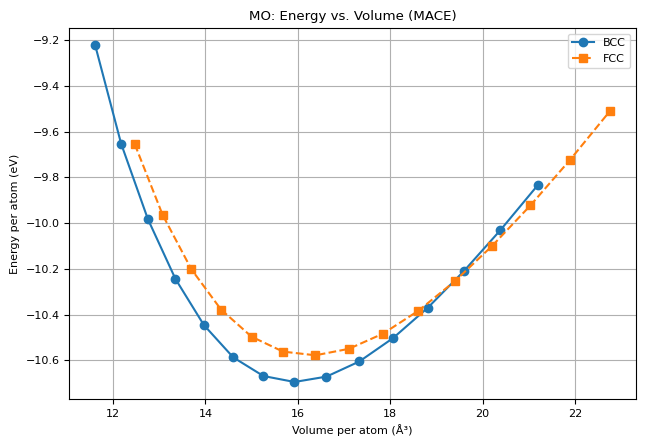

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from mace.calculators import MACECalculator

# --- Setup ---
element = "Mo"
a0_bcc = 3.170  # Approximate relaxed lattice constant for BCC
a0_fcc = 4.09  #
scaling_factors = np.linspace(0.9, 1.1, 15)

# --- Load MACE calculator ---
calc = MACECalculator(model_path="/2023-12-03-mace-128-L1_epoch-199.model")

# --- Function to compute E/V for a crystal type ---
def compute_e_vs_v(crystal, a0):
    volumes = []
    energies = []

    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)
        volumes.append(V_per_atom)
        energies.append(E_per_atom)

    return volumes, energies

# --- Compute for BCC and FCC ---
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# --- Plot ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, en_fcc, 's--', label="FCC")
plt.xlabel("Volume per atom (Å³)")
plt.ylabel("Energy per atom (eV)")
plt.title(f"{element.upper()}: Energy vs. Volume (MACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Vacancy formation Energy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from ase.optimize import BFGS
from ase import Atoms
from mace.calculators import MACECalculator

# Parameters
element = "Mo"
a0 = 3.170
supercell_size = (5, 5, 5)
fmax_tol = 1e-2
model_path = "/2023-12-03-mace-128-L1_epoch-199.model"

# Build bulk supercell
atoms_bulk = bulk(element, 'bcc', a=a0).repeat(supercell_size)
N_bulk = len(atoms_bulk)

# Assign calculator and relax bulk
atoms_bulk.calc = MACECalculator(model_path=model_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)
E_bulk = atoms_bulk.get_potential_energy()

##### Debug 1
print(f"Bulk energy: {E_bulk:.3f} eV")


# ----------------------
# Vacancy
# ----------------------
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)  # remove one atom from center
atoms_vac.calc = MACECalculator(model_path=model_path)
opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)
E_vac = atoms_vac.get_potential_energy()
vacancy_formation_energy = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk


##### Debug 2
print(f"Vacancy formation energy: {vacancy_formation_energy:.3f} eV")


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


Bulk energy: -1336.826 eV
Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Vacancy formation energy: 2.239 eV


# Nb (Niobium)

## Lattice constant

In [ ]:
from ase.build import bulk
from ase.optimize import BFGS, LBFGS
from ase.constraints import UnitCellFilter, ExpCellFilter
from mace.calculators import MACECalculator
from ase.io import write

# === Parameters ===
element = 'Nb'
a = 3.15
supercell = (5, 5, 5)
num_spercell_x = supercell[0]
model_path = "2023-12-03-mace-128-L1_epoch-199.model"
output_file = f"{element}_relaxed_cell.xyz"

# === Create BCC bulk structure ===
atoms = bulk(name=element, crystalstructure='bcc', a=a)*supercell

# === Set MACE calculator ===
calc = MACECalculator(model_path=model_path, device='cpu', default_dtype='float32')
atoms.set_calculator(calc)

# === Enable cell relaxation ===
ucf = UnitCellFilter(atoms)
#ucf = ExpCellFilter (atoms) # Gives same result
dyn = BFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log')
#dyn = LBFGS(ucf, trajectory='relax_cell.traj', logfile='relax_cell.log') # Gives same result
dyn.run(fmax=0.01)

# === Save relaxed structure ===
write(output_file, atoms)

# === Extract final lattice constant ===
relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)
print(f"Relaxed lattice constant (a): {relaxed_a:.6f} Å")


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipython-input-56-3532521663.py:20: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipython-input-56-3532521663.py:23: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Relaxed lattice constant (a): -3.313435 Å


## Cubic elastic constant

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from mace.calculators import MACECalculator
from ase.optimize import BFGS



# ---------------------------
# Setup: Load model and atoms
# ---------------------------
model_path = "/2023-12-03-mace-128-L1_epoch-199.model"
atoms = bulk("Nb", "bcc", a=3.313)
atoms.calc = MACECalculator(model_path=model_path)

"""
# The structure can be relaxed too but because as A.13 a =3.313 is uded, it does not make sense to do so
opt = BFGS(atoms)
opt.run(fmax=0.01)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()
"""

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = deepcopy(atoms)
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    return strained_atoms

def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    # Fit ΔE/V = A delta^2 → C = 2A / factor
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)  # linear fit
    A = coeffs[0]
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta  # symmetric shear
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa  # 1 eV/A^3 = 160.21766208 GPa

print("\nElastic Constants (from MACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.

Elastic Constants (from MACE model):
C11 ≈ 206.77 GPa
C12 ≈ 128.19 GPa
C44 ≈ 29.81 GPa


## Energy vs Volume

/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
Saved ΔE–V data to DeltaE_vs_V_Nb_2023-12-03-mace-128-L1_epoch-199.csv


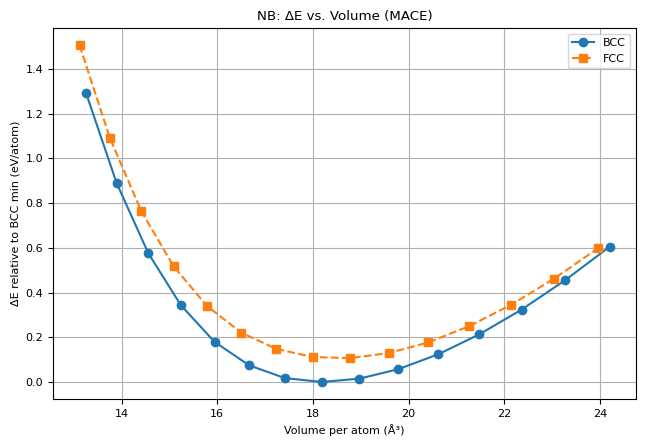

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
from ase.io import write
from mace.calculators import MACECalculator

# --- Setup ---
element = "Nb"
a0_bcc = 3.313  # Approximate relaxed lattice constant for BCC
a0_fcc = 4.16  # Approximate FCC guess
scaling_factors = np.linspace(0.9, 1.1, 15)


# --- Load MACE calculator ---
model_path="/2023-12-03-mace-128-L1_epoch-199.model"

calc = MACECalculator(model_path=model_path)

# --- Function to compute E/V for a crystal type ---
def compute_e_vs_v(crystal, a0):
    volumes, energies = [], []
    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale, cubic=True)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)
        volumes.append(V_per_atom)
        energies.append(E_per_atom)
    return np.array(volumes), np.array(energies)

# --- Compute for BCC and FCC ---
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# --- Shift energies to ΔE relative to BCC minimum ---
E_ref = en_bcc.min()
delta_en_bcc = en_bcc - E_ref
delta_en_fcc = en_fcc - E_ref

# --- Save ΔE–V to CSV (name based on model) ---
df = pd.DataFrame({
    "V_BCC": vol_bcc,
    "DeltaE_BCC": delta_en_bcc,
    "V_FCC": vol_fcc,
    "DeltaE_FCC": delta_en_fcc
})



model_name = os.path.splitext(os.path.basename(model_path))[0]
out_csv = f"DeltaE_vs_V_{element}_{model_name}.csv"

df.to_csv(out_csv, index=False)
print(f"Saved ΔE–V data to {out_csv}")

# --- Plot ΔE vs V ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
plt.xlabel("Volume per atom (Å³)")
plt.ylabel("ΔE relative to BCC min (eV/atom)")
plt.title(f"{element.upper()}: ΔE vs. Volume (MACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Vacancy formation Energy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from ase.optimize import BFGS
from ase import Atoms
from mace.calculators import MACECalculator

# Parameters
element = "Nb"
a0 = 3.313
supercell_size = (5, 5, 5)
fmax_tol = 1e-2
model_path = "/2023-12-03-mace-128-L1_epoch-199.model"

# Build bulk supercell
atoms_bulk = bulk(element, 'bcc', a=a0).repeat(supercell_size)
N_bulk = len(atoms_bulk)

# Assign calculator and relax bulk
atoms_bulk.calc = MACECalculator(model_path=model_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)
E_bulk = atoms_bulk.get_potential_energy()

##### Debug 1
print(f"Bulk energy: {E_bulk:.3f} eV")


# ----------------------
# Vacancy
# ----------------------
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)  # remove one atom from center
atoms_vac.calc = MACECalculator(model_path=model_path)
opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)
E_vac = atoms_vac.get_potential_energy()
vacancy_formation_energy = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk


##### Debug 2
print(f"Vacancy formation energy: {vacancy_formation_energy:.3f} eV")


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


Bulk energy: -1260.725 eV
Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


/usr/local/lib/python3.11/dist-packages/mace/calculators/mace.py:158: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Vacancy formation energy: 2.217 eV


# MACE Speedtest

## CPU

### MACE timing for Energy

In [ ]:
#MACE Speedtest for Energy using CPU

import torch
from ase.io import read
from mace import data, tools
from mace.tools import torch_geometric
import time
import numpy as np

# --------------------------
# Settings
# --------------------------
model_path = "2023-12-03-mace-128-L1_epoch-199.model"
xyz_path = "/content/drive/MyDrive/Colab_files/Thesis/MACE/MACE MD trajectories/MD trajectories (Alice)/Tungsten/BCC/md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data.xyz"
device = "cpu"
batch_size = 32
N_rep = 5  # number of repetitions

#Load model
torch.set_default_dtype(torch.float64)
model = torch.load(model_path, map_location=device)
model = model.to(device).double().eval()

#Read structures
atoms_list = read(xyz_path, index=":")
print(f"Loaded {len(atoms_list)} structures.")

#Convert ASE to MACE graphs
z_table = tools.utils.AtomicNumberTable([int(z) for z in model.atomic_numbers])
configs = [data.config_from_atoms(atoms) for atoms in atoms_list]
graph_list = [
    data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
    for config in configs
]
loader = torch_geometric.dataloader.DataLoader(
    graph_list, batch_size=batch_size, shuffle=False
)

#Timing
torch.cuda.synchronize() if device == "cuda" else None

times = []

for i in range(N_rep):
    start_time = time.time()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            _ = model(batch.to_dict(), compute_force=False)
    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)

torch.cuda.synchronize() if device == "cuda" else None

#Compute timing results
times = np.array(times)
num_structures = len(graph_list)
num_atoms = sum(len(cfg.positions) for cfg in configs)
avg_time = times.mean() / num_atoms
std_time = times.std(ddof=1) / num_atoms
median_time = np.median(times) / num_atoms
throughput = num_atoms / times.mean()

print(f"\nDevice: {device}")
print(f"Batch size: {batch_size}")
print(f"Repetitions: {N_rep}")
print("-----------------------------------------------")
print(f"Mean per atom:        {avg_time*1000:.8f} +/- {std_time*1000:.8f} ms")
print(f"Median per atom:      {median_time*1000:.8f} ms")
print(f"Throughput:           {throughput:.2f} atoms/s")

/tmp/ipython-input-3943137587.py:21: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(model_path, map_location=device)


Loaded 540 structures.

Device: cpu
Batch size: 32
Repetitions: 5
-----------------------------------------------
Mean per atom:        22.14887974 +/- 0.00080670 ms
Median per atom:      21.67202684 ms
Throughput:           45.15 atoms/s


### MACE timing for Force

In [ ]:
#MACE Speedtest for Force using CPU

import torch
from ase.io import read
from mace import data, tools
from mace.tools import torch_geometric
import time
import numpy as np

#Settings
model_path = "2023-12-03-mace-128-L1_epoch-199.model"
xyz_path = (
    "/content/drive/MyDrive/Colab_files/Thesis/MACE/MACE MD trajectories/"
    "MD trajectories (Alice)/Tungsten/BCC/"
    "md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data.xyz"
)
device = "cpu"
batch_size = 32
N_rep = 3  # number of repetitions

#Load model
torch.set_default_dtype(torch.float64)
model = torch.load(model_path, map_location=device)
model = model.to(device).double().eval()

#Read structures
atoms_list = read(xyz_path, index=":")
print(f"Loaded {len(atoms_list)} structures.")

#Convert ASE to MACE graphs
z_table = tools.utils.AtomicNumberTable([int(z) for z in model.atomic_numbers])
configs = [data.config_from_atoms(atoms) for atoms in atoms_list]
graph_list = [
    data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
    for config in configs
]
loader = torch_geometric.dataloader.DataLoader(
    graph_list, batch_size=batch_size, shuffle=False
)

#Timing
torch.cuda.synchronize() if device == "cuda" else None

times = []

for i in range(N_rep):
    start_time = time.time()

    for batch in loader:
        batch = batch.to(device)
        batch.positions.requires_grad_(True)
        _ = model(batch.to_dict(), compute_force=True)

    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)

torch.cuda.synchronize() if device == "cuda" else None

#Compute timing results
times = np.array(times)
num_structures = len(graph_list)
num_atoms = sum(len(cfg.positions) for cfg in configs)
avg_time = times.mean() / num_atoms
std_time = times.std(ddof=1) / num_atoms
median_time = np.median(times) / num_atoms
throughput = num_atoms / times.mean()

print(f"\nDevice: {device}")
print(f"Batch size: {batch_size}")
print(f"Repetitions: {N_rep}")
print("-----------------------------------------------")
print(f"Mean per atom:        {avg_time*1000:.8f} +/- {std_time*1000:.8f} ms")
print(f"Median per atom:      {median_time*1000:.8f} ms")
print(f"Throughput:           {throughput:.2f} atoms/s")

/tmp/ipython-input-15168942.py:23: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(model_path, map_location=device)


Loaded 540 structures.

Device: cpu
Batch size: 32
Repetitions: 3
-----------------------------------------------
Mean per atom:        0.06002696 +/- 0.00085747 s
Median per atom:      0.05962346 s
Throughput:           16.66 atoms/s


## GPU

### MACE timing for Energy

In [ ]:
#MACE Speedtest for Energy calculation using GPU

import torch
from ase.io import read
from mace import data, tools
from mace.tools import torch_geometric
import time
import numpy as np


model_path = "2023-12-03-mace-128-L1_epoch-199.model"
xyz_path = (
    "/content/drive/MyDrive/Colab_files/Thesis/MACE/MACE MD trajectories/"
    "MD trajectories (Alice)/Tungsten/BCC/"
    "md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data.xyz"
)
device = "cuda"
batch_size = 32
dtype = torch.float32
N_rep = 100     # number of repetitions

#Load model
torch.set_default_dtype(dtype)
model = torch.load(model_path, map_location=device)
model = model.to(device).to(dtype).eval()

print(f"Running on {device} with dtype {dtype} and batch size {batch_size}")

#Read structures
atoms_list = read(xyz_path, index=":")
print(f"Loaded {len(atoms_list)} structures.")

#Convert ASE to MACE graphs
z_table = tools.utils.AtomicNumberTable([int(z) for z in model.atomic_numbers])
configs = [data.config_from_atoms(atoms) for atoms in atoms_list]
graph_list = [
    data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
    for config in configs
]
loader = torch_geometric.dataloader.DataLoader(
    graph_list, batch_size=batch_size, shuffle=False
)

num_atoms = sum(len(cfg.positions) for cfg in configs)

#Warm-up (optional)
if device == "cuda":
    for _ in range(3):
        for batch in loader:
            batch = batch.to(device)
            _ = model(batch.to_dict(), compute_force=False)
    torch.cuda.synchronize()

#Timing
times = []

with torch.no_grad():
    for i in range(N_rep):
        torch.cuda.synchronize() if device == "cuda" else None
        start_time = time.time()

        for batch in loader:
            batch = batch.to(device)
            _ = model(batch.to_dict(), compute_force=False)

        torch.cuda.synchronize() if device == "cuda" else None
        end_time = time.time()

        total_time = end_time - start_time
        times.append(total_time)

times = np.array(times)

#Compute per-atom mean/median/std
mean_time_atom = times.mean() / num_atoms
std_time_atom = times.std(ddof=1) / num_atoms
median_time_atom = np.median(times) / num_atoms

#Print
print(f"Device:               {device}")
print(f"Batch size:           {batch_size}")
print(f"Repetitions:          {N_rep}")
print("--------------------------------------------------------------")
print(f"Mean per atom:        {mean_time_atom*1000:.8f} +/- {std_time_atom*1000:.8f} ms")
print(f"Median per atom:      {median_time_atom*1000:.8f} ms")


/tmp/ipython-input-2040834346.py:24: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(model_path, map_location=device)


Running on cuda with dtype torch.float32 and batch size 32
Loaded 540 structures.
Device:               cuda
Batch size:           32
Repetitions:          100
--------------------------------------------------------------
Mean per atom:        0.16461343 +/- 0.00549083 ms
Median per atom:      0.16356255 ms


### MACE timing for Force

In [ ]:
#MACE Speedtest for Force calculation using GPU

import torch
from ase.io import read
from mace import data, tools
from mace.tools import torch_geometric
import time
import numpy as np

#Settings
model_path = "2023-12-03-mace-128-L1_epoch-199.model"
xyz_path = (
    "/content/drive/MyDrive/Colab_files/Thesis/MACE/MACE MD trajectories/"
    "MD trajectories (Alice)/Tungsten/BCC/"
    "md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data.xyz"
)
device = "cuda"
batch_size = 32
dtype = torch.float32
N_rep = 100  # number of repetitions


#Load model
torch.set_default_dtype(dtype)
model = torch.load(model_path, map_location=device)
model = model.to(device).to(dtype).eval()

print(f"Running on {device} with dtype {dtype} and batch size {batch_size}")

#Read structures
atoms_list = read(xyz_path, index=":")
print(f"Loaded {len(atoms_list)} structures.")

#Convert ASE to MACE graphs
z_table = tools.utils.AtomicNumberTable([int(z) for z in model.atomic_numbers])
configs = [data.config_from_atoms(atoms) for atoms in atoms_list]
graph_list = [
    data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
    for config in configs
]
loader = torch_geometric.dataloader.DataLoader(
    graph_list, batch_size=batch_size, shuffle=False
)

num_atoms = sum(len(cfg.positions) for cfg in configs)

#Warm-up (optional)
if device == "cuda":
    for _ in range(3):
        for batch in loader:
            batch = batch.to(device)
            _ = model(batch.to_dict(), compute_force=True)
    torch.cuda.synchronize()
    print("Warm-up completed.")

# Timing
times = []

for i in range(N_rep):
    torch.cuda.synchronize() if device == "cuda" else None
    start_time = time.time()

    # Force prediction
    for batch in loader:
        batch = batch.to(device)
        _ = model(batch.to_dict(), compute_force=True)

    torch.cuda.synchronize() if device == "cuda" else None
    end_time = time.time()

    total_time = end_time - start_time
    times.append(total_time)

times = np.array(times)

#Compute per-atom results
mean_time_atom = times.mean() / num_atoms
std_time_atom = times.std(ddof=1) / num_atoms
median_time_atom = np.median(times) / num_atoms

#Print results
print("\n================ Force Prediction Timing (per atom) ================")
print(f"Device:               {device}")
print(f"Precision:            {dtype}")
print(f"Batch size:           {batch_size}")
print(f"Repetitions:          {N_rep}")
print(f"Total atoms:          {num_atoms}")
print("--------------------------------------------------------------")
print(f"Mean per atom:        {mean_time_atom*1000:.8f} +/- {std_time_atom*1000:.8f} ms")
print(f"Median per atom:      {median_time_atom*1000:.8f} ms")


/tmp/ipython-input-3441112689.py:25: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(model_path, map_location=device)


Running on cuda with dtype torch.float32 and batch size 32
Loaded 540 structures.
Warm-up completed.

================ Force Prediction Timing (per atom) ================
Device:               cuda
Precision:            torch.float32
Batch size:           32
Repetitions:          100
Total atoms:          8640
--------------------------------------------------------------
Mean per atom:        0.46374902 +/- 0.00724595 ms
Median per atom:      0.46177864 ms
